## 2017 Weather Analysis

This notebook contains the analysis of weather data for the first year of Aim 1 of the NSF/PGRP project "Adapting Perennial Crops for Climate Change: Graft Transmissible Effects of Rootstocks on Grapevine Shoots" (1546869). The manuscript(s) associated with the data can be found in the README of this GitHIb repository.

This notebook was primarily used for the generation of Supplemental Note 1 which makes the case for our handling of the irrigation treatment.

This code is provided for reproducability.

Questions about this code and project can be directed to Zachary N. Harris or Allison J. Miller.

In [1]:
library('dplyr')
library('tidyverse')
library('ggplot2')
library('lubridate')
library('scales')
library('lsmeans')
library('reshape')


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1     ✔ readr   1.3.1
✔ tibble  2.1.1     ✔ purrr   0.3.2
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ ggplot2 3.1.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date


Attaching package: ‘scales’

The following object is masked from ‘package:purrr’:

    discard

The following object is masked from ‘package:readr’:

    col_factor

Loading required

In [2]:
weather <- read.csv('2017_weather_data.csv', header=TRUE)
colnames(weather) <- c('Month', 'Day', 'Year', 'maxT', 'minT', 'Precip', 'evap', 'rad')

head(weather)

Month,Day,Year,maxT,minT,Precip,evap,rad
<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5,8,2014,78.7,62.2,1.04,0.088,7.68
5,9,2014,75.7,55.3,0.37,0.140,20.34
5,10,2014,83.7,52.5,0.00,0.211,25.96
5,11,2014,84.5,63.2,0.00,0.195,21.33
5,12,2014,85.1,53.9,0.85,0.146,15.49
5,13,2014,54.4,47.5,0.02,0.048,7.06


## Temperature

First, I will look at the temp data to see if there are any difference in 2017 for the high and low temps across the years. To do this, I will first generate a plot of the temp. range over the course of each year. This took some creative hackery to get the plot I wanted (for example, I had to create a dummy date that preserved the month/day order while making R think they came from the same 'year', \[here I chose 1904, because it and 2016 are both leap years - shout out to the fact that 1900 was not...\]). 

In [3]:
weather_temp <- weather %>% select(Month:minT) %>% gather(key, temp, 4:5)
weather_temp$date <- paste(weather_temp$Year, weather_temp$Month, weather_temp$Day, sep='-')
weather_temp$date <- as.Date(weather_temp$date)
weather_temp$Year <- as.factor(weather_temp$Year)
weather_temp <- weather_temp %>% select(Year, key:date)
head(weather_temp)

Year,key,temp,date
<fct>,<chr>,<dbl>,<date>
2014,maxT,78.7,2014-05-08
2014,maxT,75.7,2014-05-09
2014,maxT,83.7,2014-05-10
2014,maxT,84.5,2014-05-11
2014,maxT,85.1,2014-05-12
2014,maxT,54.4,2014-05-13


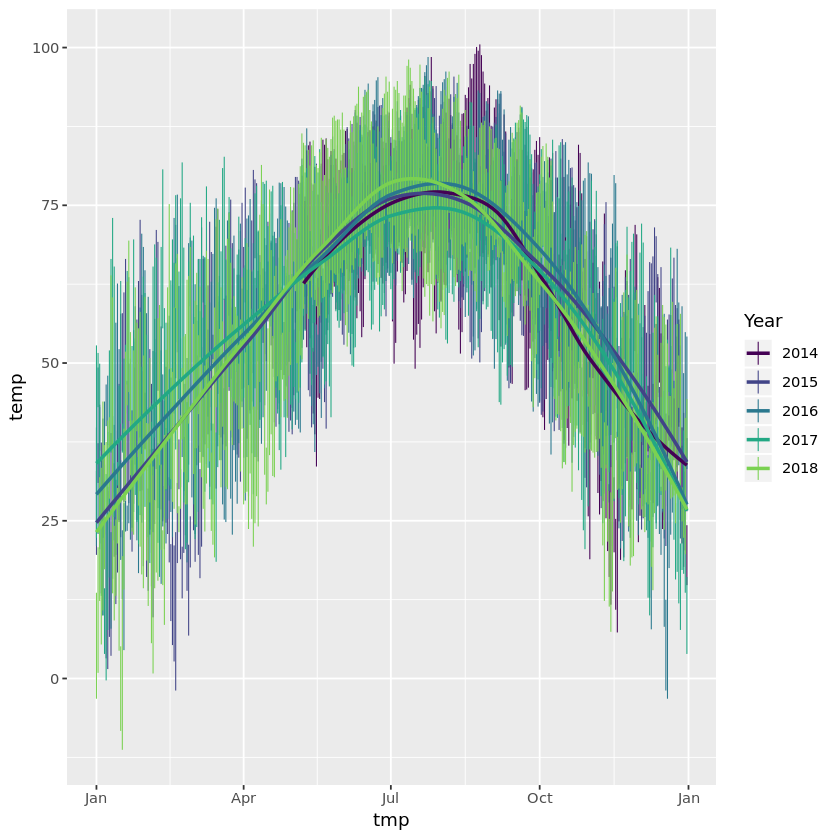

In [4]:
c_pal <- viridisLite::viridis(6)[1:5]
weather_temp$tmp <- as.Date(paste(rep("1904", length(weather_temp$date)), month(weather_temp$date), day(weather_temp$date), sep='-'))


p <- ggplot(weather_temp, aes(x=tmp, y=temp, group=factor(year(date)), color=factor(year(date))))
p + stat_summary(fun.y=mean, fun.ymin = min, fun.ymax = max, geom='pointrange', size=0.3, pch=' ') + 
    scale_color_manual(name="Year", values=c_pal) + 
    scale_x_date(labels = date_format("%b")) + 
    geom_smooth(method='loess', formula='y~x', se=FALSE)

Next, we can generate a few box plots, by year and month, to look at temp differences across years. 

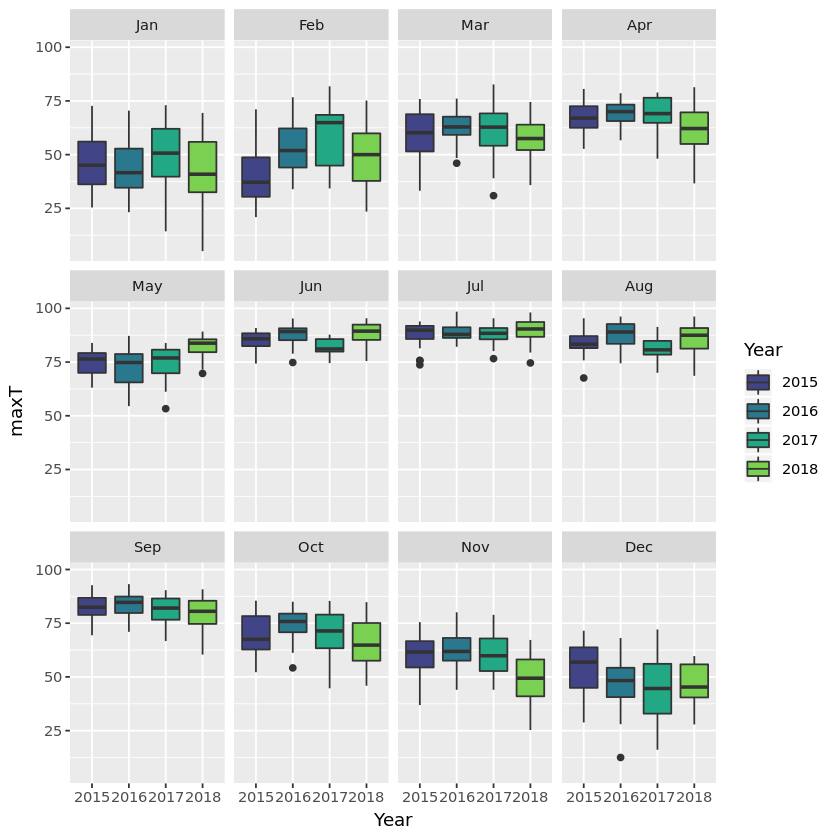

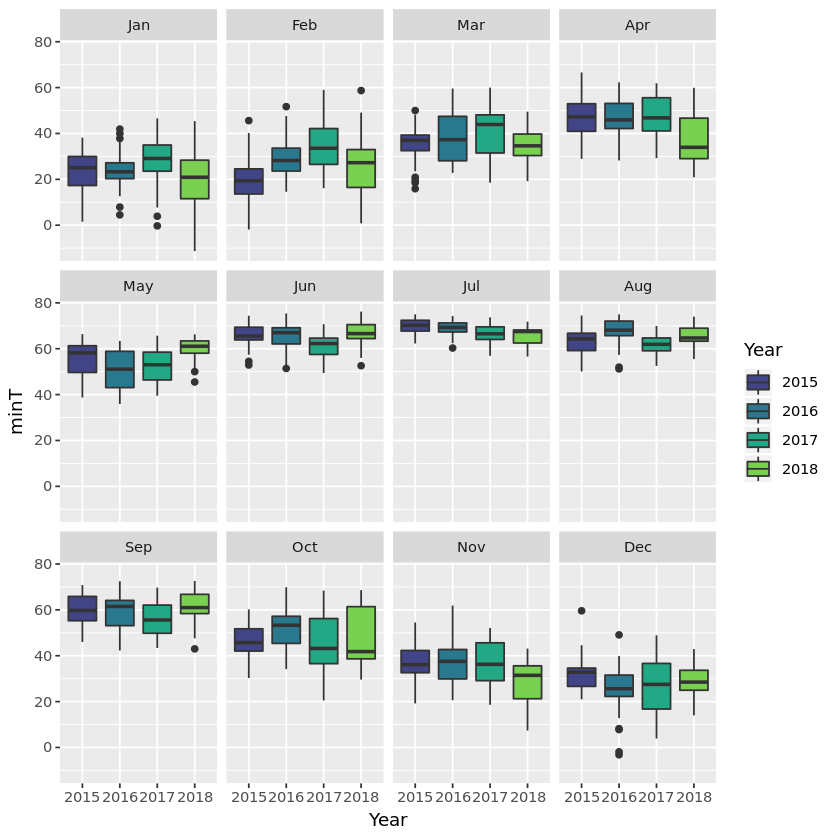

In [7]:
weather_temp <- weather %>% select(Month:rad)
weather_temp$Year <- as.factor(weather_temp$Year)
weather_temp$Month <- as.factor(weather_temp$Month)
weather_temp$Month <- factor(weather_temp$Month, labels=c('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                                           'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))


weather_temp <- weather_temp[weather_temp$Year != 2014,]

p <- ggplot(weather_temp, aes(x=Year, y=maxT, fill=factor(Year)))
p + geom_boxplot() + 
    scale_fill_manual(name="Year", values=c_pal[2:5]) + 
    facet_wrap('Month')

p <- ggplot(weather_temp, aes(x=Year, y=minT, fill=factor(Year)))
p + geom_boxplot() + 
    scale_fill_manual(name="Year", values=c_pal[2:5]) + 
    facet_wrap('Month')

After establishing the visualization, I want to actually do the stats on which to make quantitative statements. Due to the way the data are presented (only max and min temps), I am going to fit two models: One ANOVA modelling maxT ~ Month:Year and one model modelling minT ~ Month:Year 

In [8]:
maxTlm <- lm(maxT ~ Month*Year, data=weather_temp)

#change options for the lms
oldc <- getOption("contrasts")
options(contrasts=c('contr.sum','contr.poly'))

maxTanova <- car::Anova(maxTlm, type=3)

# reset base contrasts so nothing is too broken
options(contrasts = oldc)

In [9]:
minTlm <- lm(minT ~ Month*Year, data=weather_temp)

#change options for the lms
oldc <- getOption("contrasts")
options(contrasts=c('contr.sum','contr.poly'))

minTanova <- car::Anova(minTlm, type=3)

# reset base contrasts so nothing is too broken
options(contrasts = oldc)

In [10]:
maxTanova
minTanova

,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),64460.1600,1,712.000599,2.290278e-127
Month,84854.3753,11,85.206070,1.579187e-147
Year,814.9284,3,3.000455,2.961184e-02
Month:Year,16265.7947,33,5.444404,1.551481e-20
Residuals,127924.3392,1413,NA,NA


,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),16504.971,1,216.414570,1.092191e-45
Month,94500.908,11,112.645808,2.719237e-184
Year,1068.978,3,4.672178,2.970665e-03
Month:Year,13516.361,33,5.370535,3.804377e-20
Residuals,107763.186,1413,NA,NA


Following these ANOVAs, I am interested in knowing where the differences are popping out. To do this, we can fit pairwise t-tests to all groups of interest. Because emmeans doesn't seem to let me choose my a priori comparisons, I then subset those results so that only the same month in multiple years is compared (72 tests total). I then fit an FDR p-value corrections to remove potential false positives. 

In [11]:
maxT.emm <- emmeans(maxTlm, ~Month:Year)
res <- pairs(maxT.emm)
res <- as.data.frame(res)
res <- transform(res, comps=colsplit(contrast, split = "-", names = c('p1', 'p2')))
res <- transform(res, md1=colsplit(comps.p1, split = ",", names = c('m1', 'y1')))
res <- transform(res, md2=colsplit(comps.p2, split = ",", names = c('m2', 'y2')))
res$md2.m2 <- trimws(res$md2.m2, which='left')
res <- res[res$md1.m1 == res$md2.m2,] %>% select(contrast:p.value)
res$padj <- p.adjust(res$p.value, method='fdr')
res[res$padj < 0.05,]

,contrast,estimate,SE,df,t.ratio,p.value,padj
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
59,"Feb,2015 - Feb,2016",-13.78091,2.520954,1413,-5.466546,5.810979e-05,1.394635e-03
71,"Feb,2015 - Feb,2017",-19.97143,2.542971,1413,-7.853579,7.628453e-12,5.492486e-10
827,"Nov,2016 - Nov,2018",13.54000,2.456744,1413,5.511360,4.550163e-05,1.394635e-03


In [12]:
minT.emm <- emmeans(minTlm, ~Month:Year)
res <- pairs(minT.emm)
res <- as.data.frame(res)
res <- transform(res, comps=colsplit(contrast, split = "-", names = c('p1', 'p2')))
res <- transform(res, md1=colsplit(comps.p1, split = ",", names = c('m1', 'y1')))
res <- transform(res, md2=colsplit(comps.p2, split = ",", names = c('m2', 'y2')))
res$md2.m2 <- trimws(res$md2.m2, which='left')
res <- res[res$md1.m1 == res$md2.m2,] %>% select(contrast:p.value)
res$padj <- p.adjust(res$p.value, method='fdr')
res[res$padj < 0.05,]

,contrast,estimate,SE,df,t.ratio,p.value,padj
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
71,"Feb,2015 - Feb,2017",-15.25357,2.333996,1413,-6.535389,9.900382e-08,7.128275e-06


In after this exercise, it seems that 2017 is popping out as slightly different in february comparisons. Additional differences arrise from November in the 2016/2018 comparisons and February in the 2015/2016 comparisons. From this, we can conclude that for our year of interest, 2017, we see pretty minor differences. The only significant difference is in February which is prior to our sampling window. 

## Total Precipitation

In [13]:
weather_tmp <- weather %>% select(Month:rad)
weather_tmp$date <- paste(weather_tmp$Year, weather_tmp$Month, weather_tmp$Day, sep='-')
weather_tmp$date <- as.Date(weather_tmp$date)
weather_tmp$Year <- as.factor(weather_tmp$Year)
weather_tmp <- weather_tmp[weather_tmp$Year != 2014,] %>% select(Year, Precip, date)
head(weather_tmp)

,Year,Precip,date
,<fct>,<dbl>,<date>
239,2015,0.01,2015-01-01
240,2015,0.31,2015-01-02
241,2015,0.30,2015-01-03
242,2015,0.00,2015-01-04
243,2015,0.00,2015-01-05
244,2015,0.00,2015-01-06


At least for the first pass, I think the best way to think about the precip data is as a cumulative precipitation. This allows us to make statements about how much rain has accumulated since a given point and compare that to predictions from estimated evapotranspiration losses. To do this, I am going to subset the data by year, calculate cumulative precip, and then re-concatentate those data frames. 

In [14]:
get_accumulatedPrecip <- function(df){
    acc.precip <- rep(0, length(df$Precip))
    for (i in 1:length(acc.precip)){
        if (i == 1){
            acc.precip[i] <- df$Precip[i]
        } else {
            acc.precip[i] <- acc.precip[i-1] + df$Precip[i]
        }
    }
    df$Precip <- acc.precip
    return(df)
}

weather_tmp_2015 <- weather_tmp[weather_tmp$Year == 2015,]
weather_tmp_2016 <- weather_tmp[weather_tmp$Year == 2016,]
weather_tmp_2017 <- weather_tmp[weather_tmp$Year == 2017,]
weather_tmp_2018 <- weather_tmp[weather_tmp$Year == 2018,]

weather_tmp_2015 <- get_accumulatedPrecip(weather_tmp_2015)
weather_tmp_2016 <- get_accumulatedPrecip(weather_tmp_2016)
weather_tmp_2017 <- get_accumulatedPrecip(weather_tmp_2017)
weather_tmp_2018 <- get_accumulatedPrecip(weather_tmp_2018)

weather_tmp <- rbind(weather_tmp_2015, weather_tmp_2016, weather_tmp_2017, weather_tmp_2018)


head(weather_tmp)

,Year,Precip,date
,<fct>,<dbl>,<date>
239,2015,0.01,2015-01-01
240,2015,0.32,2015-01-02
241,2015,0.62,2015-01-03
242,2015,0.62,2015-01-04
243,2015,0.62,2015-01-05
244,2015,0.62,2015-01-06


To plot all on the same x-axis, I need to project all data to a common year. To avoid conflicts with 2016 being a leap year, I chose 1904.

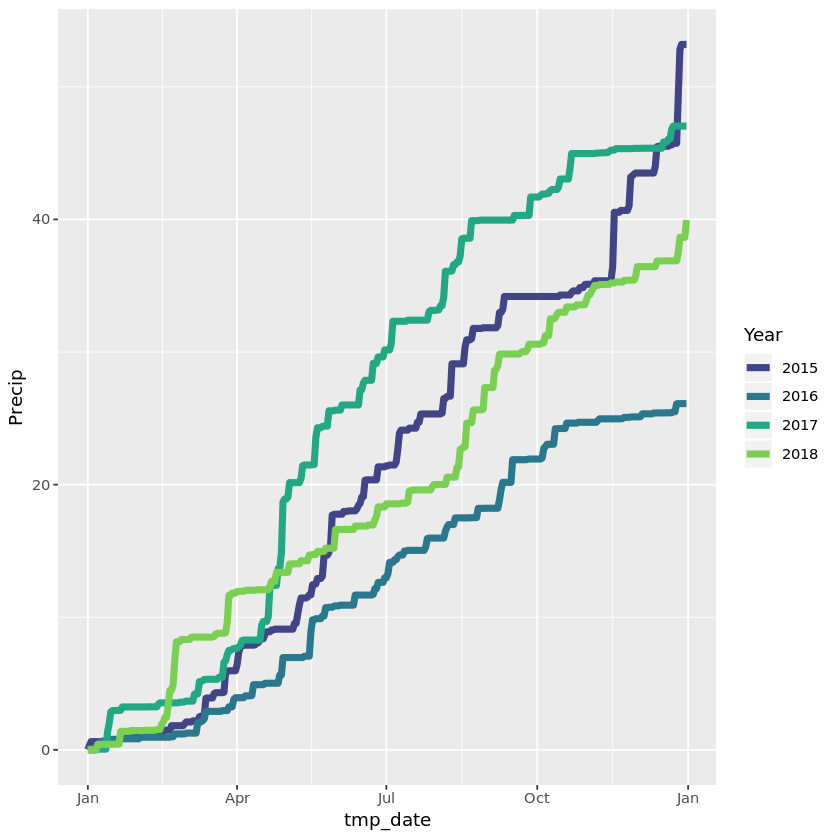

In [15]:
weather_tmp$tmp_date <- as.Date(paste(rep("1904", length(weather_tmp$date)), month(weather_tmp$date), day(weather_tmp$date), sep='-'))

p <- ggplot(weather_tmp, aes(x=tmp_date, y=Precip, color=Year)) + 
     geom_line(lwd=2) + 
     #geom_area(aes(fill=Year), position='identity', alpha=0.3) + 
     scale_color_manual(name="Year", values=c_pal[2:5]) + 
     scale_x_date(labels = date_format("%b"))
p

Since we are looking at accumulated precipitation, I think the appropriate question to ask is, 'Are the slopes of the above plot different?' Qualitatively, probably. But to do this, I start with a linear model framework under which I can directly compare those slopes. First, I fit a linear model with accumulated precip ~ year \* integer(day). This allows the estimation and contrasting of slopes using emmeans::emtrends. (see: https://stats.stackexchange.com/questions/33013/what-test-can-i-use-to-compare-slopes-from-two-or-more-regression-models)

In [16]:
weather_tmp$ndays <- as.integer(as.Date('2015-01-01') - weather_tmp$tmp_date)
weather_tmp$ndays <- abs(weather_tmp$ndays - max(weather_tmp$ndays))
head(weather_tmp)
tail(weather_tmp)

,Year,Precip,date,tmp_date,ndays
,<fct>,<dbl>,<date>,<date>,<int>
239,2015,0.01,2015-01-01,1904-01-01,0
240,2015,0.32,2015-01-02,1904-01-02,1
241,2015,0.62,2015-01-03,1904-01-03,2
242,2015,0.62,2015-01-04,1904-01-04,3
243,2015,0.62,2015-01-05,1904-01-05,4
244,2015,0.62,2015-01-06,1904-01-06,5


,Year,Precip,date,tmp_date,ndays
,<fct>,<dbl>,<date>,<date>,<int>
1694,2018,37.53,2018-12-26,1904-12-26,360
1695,2018,38.65,2018-12-27,1904-12-27,361
1696,2018,38.65,2018-12-28,1904-12-28,362
1697,2018,38.65,2018-12-29,1904-12-29,363
1698,2018,38.65,2018-12-30,1904-12-30,364
1699,2018,39.96,2018-12-31,1904-12-31,365


In [17]:
preciplm <- lm(Precip ~ ndays*Year, data=weather_tmp)

#change options for the lms
oldc <- getOption("contrasts")
options(contrasts=c('contr.sum','contr.poly'))

precipAnova <- car::Anova(preciplm, type=3)

# reset base contrasts so nothing is too broken
options(contrasts = oldc)

In [18]:
precip.emt <- emtrends(preciplm, 'Year', var='ndays')
as.data.frame(precip.emt)
res <- pairs(precip.emt)
res <- as.data.frame(res)
res

Year,ndays.trend,SE,df,lower.CL,upper.CL
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2015,0.14045657,0.001151375,1453,0.13819803,0.14271510
2016,0.08542745,0.001149218,1453,0.08317314,0.08768175
2017,0.15151956,0.001151375,1453,0.14926103,0.15377810
2018,0.11016553,0.001151375,1453,0.10790700,0.11242407


contrast,estimate,SE,df,t.ratio,p.value
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2015 - 2016,0.05502912,0.001626766,1453,33.827310,0.000000e+00
2015 - 2017,-0.01106300,0.001628290,1453,-6.794241,9.402013e-11
2015 - 2018,0.03029103,0.001628290,1453,18.602965,0.000000e+00
2016 - 2017,-0.06609211,0.001626766,1453,-40.627919,0.000000e+00
2016 - 2018,-0.02473809,0.001626766,1453,-15.206911,0.000000e+00
2017 - 2018,0.04135403,0.001628290,1453,25.397206,0.000000e+00


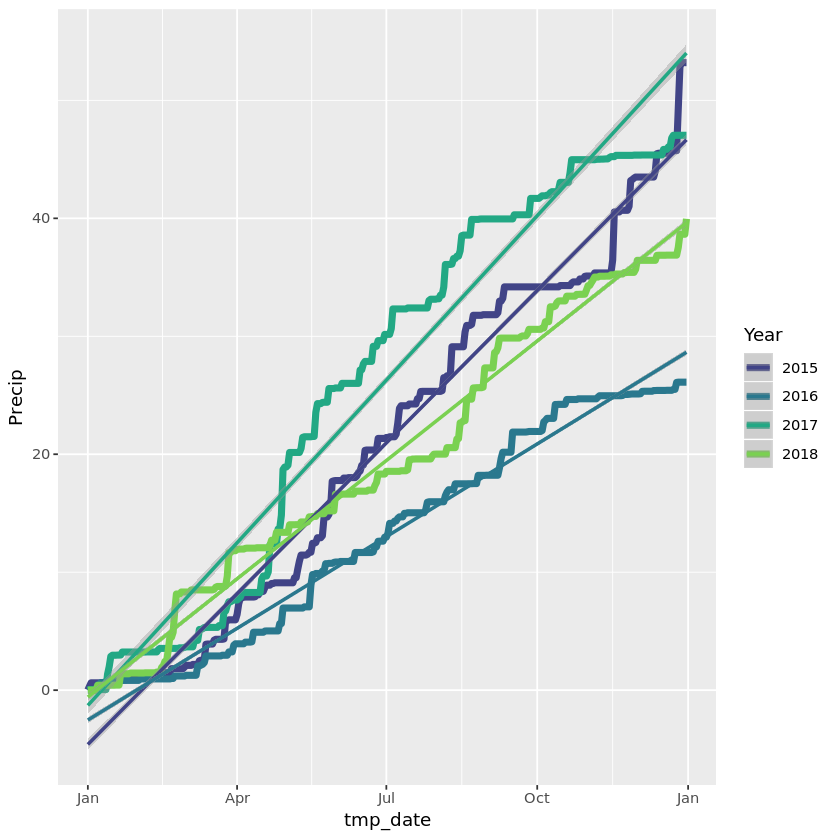

In [19]:
p <- ggplot(weather_tmp, aes(x=tmp_date, y=Precip, color=Year)) + 
     geom_line(lwd=2) + 
     #geom_area(aes(fill=Year), position='identity', alpha=0.3) + 
     scale_color_manual(name="Year", values=c_pal[2:5]) + 
     scale_x_date(labels = date_format("%b")) + 
     geom_smooth(method='lm')
p

## Short Crop Evapotranspiration

In [20]:
weather_tmp <- weather %>% select(Month:rad)
weather_tmp$date <- paste(weather_tmp$Year, weather_tmp$Month, weather_tmp$Day, sep='-')
weather_tmp$date <- as.Date(weather_tmp$date)
weather_tmp$Year <- as.factor(weather_tmp$Year)
weather_tmp <- weather_tmp[weather_tmp$Year != 2014,] %>% select(Year, evap, date)
head(weather_tmp)

,Year,evap,date
,<fct>,<dbl>,<date>
239,2015,0.018,2015-01-01
240,2015,0.008,2015-01-02
241,2015,0.015,2015-01-03
242,2015,0.022,2015-01-04
243,2015,0.038,2015-01-05
244,2015,0.042,2015-01-06


Since the values in this table are the reference value for ET losses, (see slide 57, [here](https://dnr.mo.gov/mowaterplan/documents/2017-11-15-agriculturalslides.pdf)) we need to figure out the crop coefficient ($K_c$) for grapevine to actually make the comparisons with rainfall. Generally speaking, ($K_c$) varies across the year reaching maximal values around the end of July. There is obviously a huge geographic signal in the value of ($K_c$), but as of now, I do not have a value for Mount Vernon, MO. Luckily, there doesn't seem to be a lot of variance in the literature. For example, [this paper](https://link.springer.com/article/10.1007/s00271-003-0067-5) identified maximal values of 1.08 in 1991 and 1993 in a California Thompson Seedless vineyard. [This satellite based study](https://www.sciencedirect.com.sci-hub.tw/science/article/pii/S0378377410002428) estimated a maximal value of 0.5 in a Southeastern Spain vineyard growing primarily Cencibel (with small proportions of Cab. Sav., Shiraz, and Merlot). [An Israeli Cab. Sab study](https://www.sciencedirect.com/science/article/pii/S0378377419300423) found maximal vlues of 0.8 to 0.9, and an [Italian experiment](https://link.springer.com.sci-hub.se/article/10.1007/s00271-016-0510-z) estimated the maximal value to be ~0.80 in a Vermentino vineyard. 

In 1977, the FAO released a report titled the [FAO Irrigation and Drainage Paper 24](http://www.fao.org/3/a-f2430e.pdf) highlighting Crop Water Requirements. In the report (page 50) they reported estimated ($K_c$) values for Concord (a North American hybrid). They report maximal values of 0.80 to 0.85 in humid regions with killing frosts. This work was expanded [in 1990 when Grimes and Williams](https://dl.sciencesocieties.org.sci-hub.tw/publications/cs/abstracts/30/2/CS0300020255) identified a polynomial function to estimate $K_c$ for Thompson Seedless in the San Joaqiun Valley of California: $K_c = -1.52 + 0.0231*DOY - 0.0000568*DOY^2$, DOY = Day of Year. Both the FOA model and the Grimes and Williams model were reported as overestimates for Riesling, Chenin blanc, and Cab. Sav in Washington State [see Evans paper here](https://www.sciencedirect.com.sci-hub.se/science/article/pii/0378377493900359?via%3Dihub). 

In total, these all seem to suggest that a maximal value for SW MO would be in the range of 0.8 and 0.9, although it could be as high as 1.08. It is unlikely that the maximal value would be lower 0.5, but we can use the model from Grimes and Williams to model both scenarios. As was reported by Evans, it is likely that this model will overestimate under either paradigm. 

Let us start by generating the curves for those models with maximal values at 0.5 and 1.08. Note that I am not recreating the Grimes and Williams function, I am simply adjusting the y-intercept so I can get to the values I am interested in. This means that in the case of max_Ks = 1.08, the window of positive values is widened. In the case of max_Ks = 0.5, the window is narrowed. 

,idx,paradigm,Ks
,<dbl>,<chr>,<dbl>
1093,361,max0.5,0
1094,362,max0.5,0
1095,363,max0.5,0
1096,364,max0.5,0
1097,365,max0.5,0
1098,366,max0.5,0


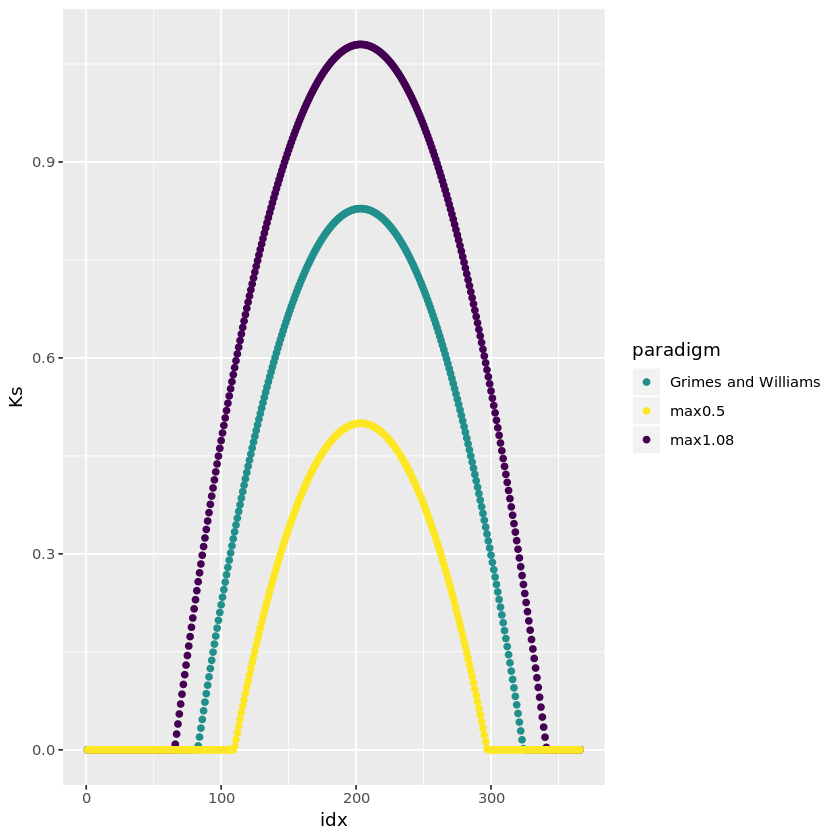

In [21]:
estimate_ks <- function(y_int, vector_of_days){
    return(y_int + 0.0231 * vector_of_days - 0.0000568 * vector_of_days^2)
}

ks <- matrix(nrow=366, ncol=4)
ks[,1] <- estimate_ks(y_int=-1.52, c(1:366))
adjustment <- max(ks[,1]) - 1.08
ks[,2] <- estimate_ks(y_int=(-1.52-adjustment), c(1:366))
adjustment <- max(ks[,1]) - 0.5
ks[,3] <- estimate_ks(y_int=(-1.52-adjustment), c(1:366))
ks[,4] <- 1:366
colnames(ks) <- c('Grimes and Williams', 'max1.08', 'max0.5', 'idx')

ks_gather <- gather(as.data.frame(ks), key='paradigm', value='Ks', -idx)
ks_gather[ks_gather < 0] <- 0
tail(ks_gather)

cols <- viridisLite::viridis(3)[c(2, 3, 1)]

p <- ggplot(ks_gather, aes(x=idx, y=Ks, color=paradigm))
p + geom_point() + scale_color_manual(values=cols)

The entire point of working through these values is to find the factor by which to muliply the reference ET loss from the weather station. Here, I simply break the large data frame down, multiply it by the appropriately indexed Ks under both regimes and create new master weather data frames for ET. 

In [22]:
get_accumulatedEvap <- function(df){
    acc.evap <- rep(0, length(df$evap))
    for (i in 1:length(acc.evap)){
        if (i == 1){
            acc.evap[i] <- df$evap[i]
        } else {
            acc.evap[i] <- acc.evap[i-1] + df$evap[i]
        }
    }
    df$evap <- acc.evap
    return(df)
}

# Figure out total evap under minimum crop coefficient

for (year in c('2015', '2016', '2017', '2018')){
    if (year == '2016'){
        end_idx <- 366
    } else {
        end_idx <- 365
    }
    temp_df <- weather_tmp[weather_tmp$Year == as.integer(year),]
    temp_df$evap_min <- temp_df$evap * ks_gather[ks_gather$paradigm == 'max0.5',]$Ks[1:end_idx]
    colnames(temp_df) <- c('Year', 'evap_total', 'date', 'evap')
    temp_df <- get_accumulatedEvap(temp_df)
    temp_df$evap_max <- temp_df$evap_total * ks_gather[ks_gather$paradigm == 'max1.08',]$Ks[1:end_idx]
    colnames(temp_df) <- c('Year', 'evap_total', 'date', 'evap_min', 'evap')
    temp_df <- get_accumulatedEvap(temp_df)
    colnames(temp_df) <- c('Year', 'evap', 'date', 'evap_min', 'evap_max')
    temp_df <- get_accumulatedEvap(temp_df)
    if (as.integer(year) == 2015){
        evap_projections <- temp_df
    } else {
        evap_projections <- rbind(evap_projections, temp_df)
    }
}

tail(evap_projections)

,Year,evap,date,evap_min,evap_max
,<fct>,<dbl>,<date>,<dbl>,<dbl>
1694,2018,38.640,2018-12-26,10.16358,28.50635
1695,2018,38.701,2018-12-27,10.16358,28.50635
1696,2018,38.726,2018-12-28,10.16358,28.50635
1697,2018,38.742,2018-12-29,10.16358,28.50635
1698,2018,38.764,2018-12-30,10.16358,28.50635
1699,2018,38.780,2018-12-31,10.16358,28.50635


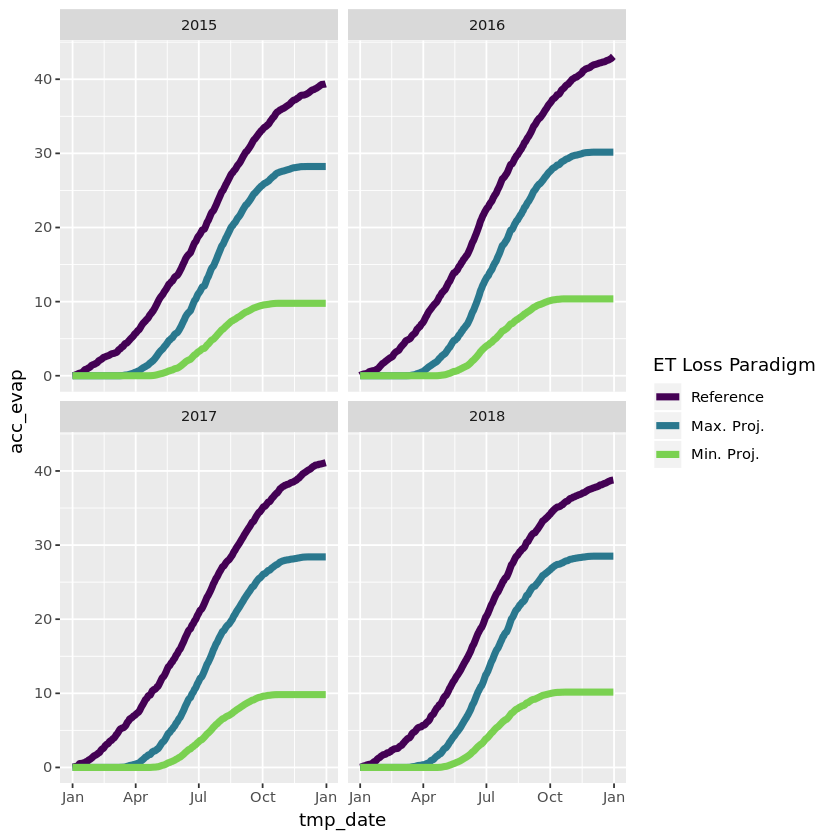

In [23]:
evap_projections$tmp_date <- as.Date(paste(rep("1904", length(evap_projections$date)), month(evap_projections$date), day(evap_projections$date), sep='-'))
to_plot <- gather(evap_projections, key='paradigm', value='acc_evap', -Year, -date, -tmp_date)

p <- ggplot(to_plot, aes(x=tmp_date, y=acc_evap, color=paradigm)) + 
     geom_line(lwd=2) + 
     #geom_area(aes(fill=Year), position='identity', alpha=0.3) + 
     scale_color_manual(name="ET Loss Paradigm", values=c_pal[c(1,3,5)], labels=c('Reference', 'Max. Proj.', 'Min. Proj.')) + 
     scale_x_date(labels = date_format("%b")) + 
     facet_wrap('Year')
p

Following these two analyses, we have the total rainfall for the vineyard in 2015 through 2019, and a range of predicted values for evapotranspiration losses. At the moment, it is unclear what the actual $K_c$ used in the vineyard is, but we do know the approximate irrigation treatment. On a weekly basis, the difference between the corrected ET loss and the rainfall is calculated. For the 'full' treatment, the sum over that difference is applied to the vines. For the 'RDI' vines, only 50% of that value is replaced. And in the 'none' treatment, no water is replaced. 

My logic here is to show the difference between the predicted rainfall and the projected ET losses across years. First, I will show this under the maximum $K_c$ design, and then under the minimum. 

In [24]:
weather_tmp <- weather %>% select(Month:rad)
weather_tmp$date <- paste(weather_tmp$Year, weather_tmp$Month, weather_tmp$Day, sep='-')
weather_tmp$date <- as.Date(weather_tmp$date)
weather_tmp$Year <- as.factor(weather_tmp$Year)
weather_tmp <- weather_tmp[weather_tmp$Year != 2014,] %>% select(Year, Precip, date)

weather_tmp_2015 <- weather_tmp[weather_tmp$Year == 2015,]
weather_tmp_2016 <- weather_tmp[weather_tmp$Year == 2016,]
weather_tmp_2017 <- weather_tmp[weather_tmp$Year == 2017,]
weather_tmp_2018 <- weather_tmp[weather_tmp$Year == 2018,]

weather_tmp_2015 <- get_accumulatedPrecip(weather_tmp_2015)
weather_tmp_2016 <- get_accumulatedPrecip(weather_tmp_2016)
weather_tmp_2017 <- get_accumulatedPrecip(weather_tmp_2017)
weather_tmp_2018 <- get_accumulatedPrecip(weather_tmp_2018)

weather_tmp <- rbind(weather_tmp_2015, weather_tmp_2016, weather_tmp_2017, weather_tmp_2018)

df <- merge(weather_tmp, evap_projections, on='date', how='left')
df <- df %>% 
      dplyr::select(Year, date, tmp_date, Precip, evap_min, evap_max) %>%
      gather(key='feature', value='cummulative.water', -Year, -date, -tmp_date)
head(df)

Year,date,tmp_date,feature,cummulative.water
<fct>,<date>,<date>,<chr>,<dbl>
2015,2015-01-01,1904-01-01,Precip,0.01
2015,2015-01-02,1904-01-02,Precip,0.32
2015,2015-01-03,1904-01-03,Precip,0.62
2015,2015-01-04,1904-01-04,Precip,0.62
2015,2015-01-05,1904-01-05,Precip,0.62
2015,2015-01-06,1904-01-06,Precip,0.62


Year,tmp_date
<dbl>,<date>
2016,1904-06-14
2017,1904-05-22
2017,1904-07-30
2017,1904-09-25


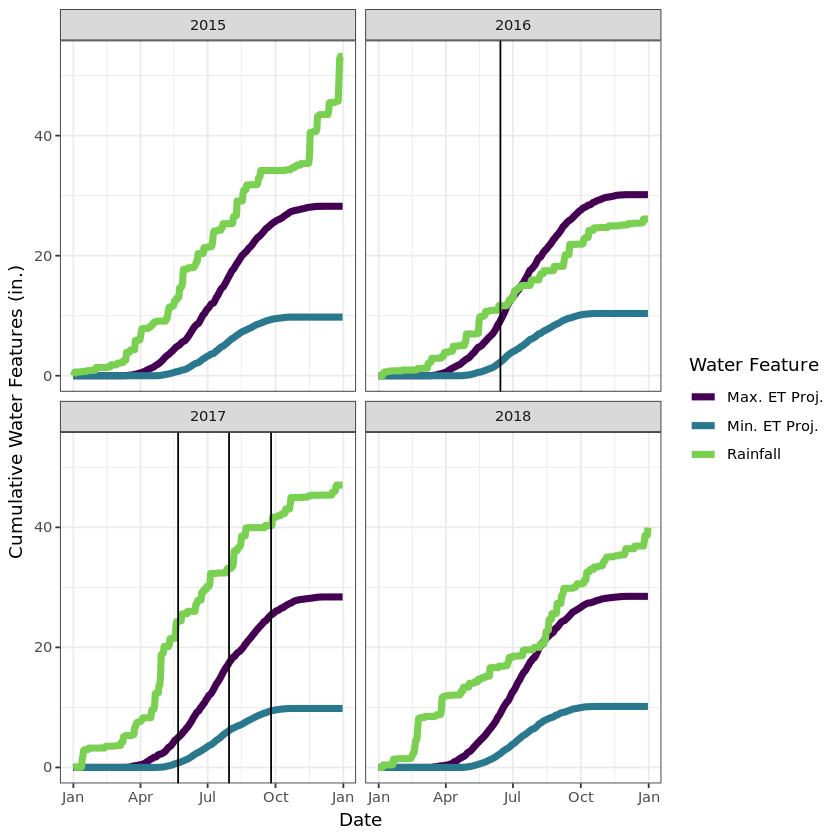

In [25]:
vline.year <- c(2016, 2017, 2017, 2017)
vline.date <- c(as.Date('1904-06-14'), as.Date('1904-05-22'), as.Date('1904-07-30'), as.Date('1904-09-25'))
vline <- data.frame('Year'=vline.year, "tmp_date"=vline.date)
vline


snFig2a <- ggplot(df, aes(x=tmp_date, y=cummulative.water, color=feature)) + 
     geom_line(lwd=2) + 
     #geom_area(aes(fill=Year), position='identity', alpha=0.3) + 
     scale_color_manual(name="Water Feature", values=c_pal[c(1,3,5)], labels=c('Max. ET Proj.', 'Min. ET Proj.', 'Rainfall')) + 
     scale_x_date(labels = date_format("%b")) +
     facet_wrap('Year') + 
     geom_vline(data=vline, aes(xintercept=tmp_date)) + 
     xlab('Date') + ylab('Cumulative Water Features (in.)') + theme_bw()

snFig2a 

Everything above this point seems to support the idea that the rainfall in 2017 was too substantial for the irrigation treatment to make any difference. However we have yet to model this on a week-by-week basis, or at the minimum, we have yet to model the data in the range that we are actuall interested in which is between the start of the irrigation treatment to the harvesting of the vineyard. Here, I will work through the week-by-week basis as the irrigation treatment is based on weekly sums. 

In [274]:
day(tail(df)$tmp_date)

[1] 26 27 28 29 30 31

In [226]:
weather_tmp <- weather %>% select(Month:rad)
weather_tmp$date <- paste(weather_tmp$Year, weather_tmp$Month, weather_tmp$Day, sep='-')
weather_tmp$date <- as.Date(weather_tmp$date)
weather_tmp$Year <- as.factor(weather_tmp$Year)
weather_tmp <- weather_tmp[weather_tmp$Year != 2014,] %>% select(Year, Precip, date, evap)
weather_tmp$tmp_date <- as.Date(paste(rep("1904", length(weather_tmp$date)), 
                                           month(weather_tmp$date), day(weather_tmp$date), sep='-'))
weather_tmp$Week <- week(weather_tmp$date)
weather_tmp$Week_year <- paste(weather_tmp$Year, weather_tmp$Week, sep='_')
head(weather_tmp)
tail(weather_tmp)

,Year,Precip,date,evap,tmp_date,Week,Week_year
,<fct>,<dbl>,<date>,<dbl>,<date>,<dbl>,<chr>
239,2015,0.01,2015-01-01,0.018,1904-01-01,1,2015_1
240,2015,0.31,2015-01-02,0.008,1904-01-02,1,2015_1
241,2015,0.30,2015-01-03,0.015,1904-01-03,1,2015_1
242,2015,0.00,2015-01-04,0.022,1904-01-04,1,2015_1
243,2015,0.00,2015-01-05,0.038,1904-01-05,1,2015_1
244,2015,0.00,2015-01-06,0.042,1904-01-06,1,2015_1


,Year,Precip,date,evap,tmp_date,Week,Week_year
,<fct>,<dbl>,<date>,<dbl>,<date>,<dbl>,<chr>
1694,2018,0.65,2018-12-26,0.021,1904-12-26,52,2018_52
1695,2018,1.12,2018-12-27,0.061,1904-12-27,52,2018_52
1696,2018,0.00,2018-12-28,0.025,1904-12-28,52,2018_52
1697,2018,0.00,2018-12-29,0.016,1904-12-29,52,2018_52
1698,2018,0.00,2018-12-30,0.022,1904-12-30,52,2018_52
1699,2018,1.31,2018-12-31,0.016,1904-12-31,53,2018_53


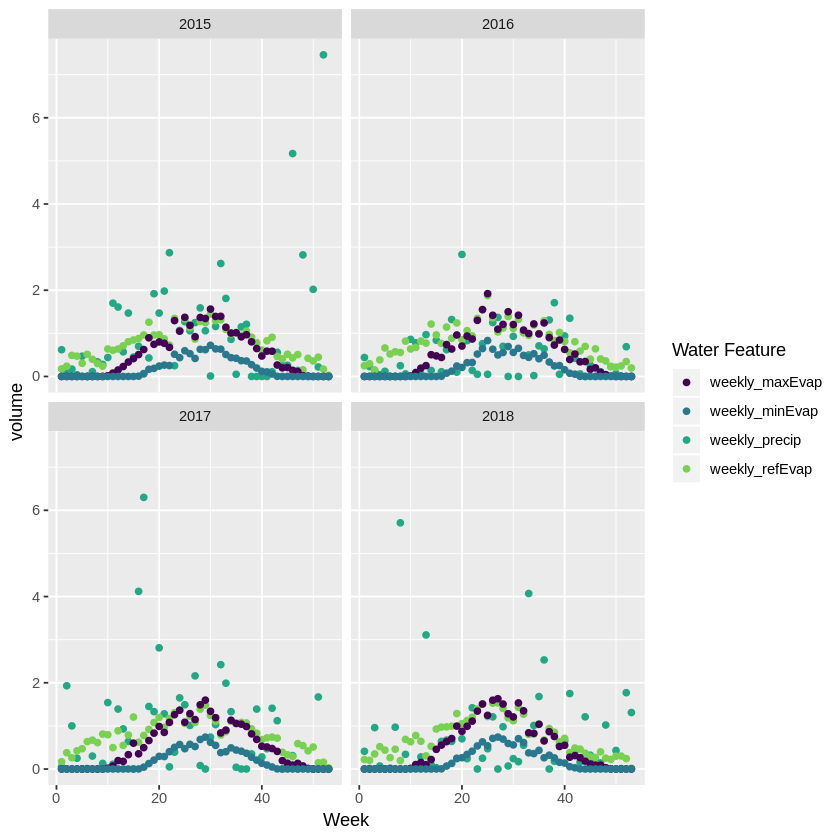

In [272]:
to_plot <- weather_tmp %>% dplyr::select(Year, Week_year, Precip, evap)

for (year in c('2015', '2016', '2017', '2018')){
    if (year == '2016'){
        end_idx <- 366
    } else {
        end_idx <- 365
    }
    temp_df <- to_plot[to_plot$Year == as.integer(year),]
    temp_df$evap_min <- temp_df$evap * ks_gather[ks_gather$paradigm == 'max0.5',]$Ks[1:end_idx]
    colnames(temp_df) <- c('Year', 'Week_year', 'Precip', 'evap', 'minEvap')
    temp_df$evap_max <- temp_df$evap * ks_gather[ks_gather$paradigm == 'max1.08',]$Ks[1:end_idx]
    colnames(temp_df) <- c('Year', 'Week_year', 'Precip', 'evap', 'minEvap', 'maxEvap')
    if (as.integer(year) == 2015){
        evap_projections <- temp_df
    } else {
        evap_projections <- rbind(evap_projections, temp_df)
    }
}

to_plot <- evap_projections %>% group_by(Week_year) %>% 
                           summarise(weekly_precip=sum(Precip), weekly_refEvap=sum(evap), 
                                     weekly_maxEvap=sum(maxEvap), weekly_minEvap=sum(minEvap)) %>% 
                           separate(Week_year, into=c('Year', 'Week'), sep='_')

to_plot$Week <- as.integer(to_plot$Week)
to_plot$Year <- as.factor(to_plot$Year)
to_plot <- to_plot %>% gather(key='GL', value='volume', -Year, -Week)

p <- ggplot(to_plot, aes(x=Week, y=volume, color=GL)) + 
     geom_point() + 
     #geom_area(aes(fill=Year), position='identity', alpha=0.3) + 
     scale_color_manual(name="Water Feature", values=c_pal[c(1,3,4,5)]) + #, labels=c('Max. Proj.', 'Min. Proj.', 'Precip.')) + 
     #scale_x_date(labels = date_format("%b")) + 
     facet_wrap('Year')
p

In [265]:
week("2016-06-14")
week("2017-09-25")
week("2017-05-22")
week("2017-07-30")

[1] 24

[1] 39

[1] 21

[1] 31

Year,tmp_date
<dbl>,<dbl>
2016,24
2017,21
2017,31
2017,39


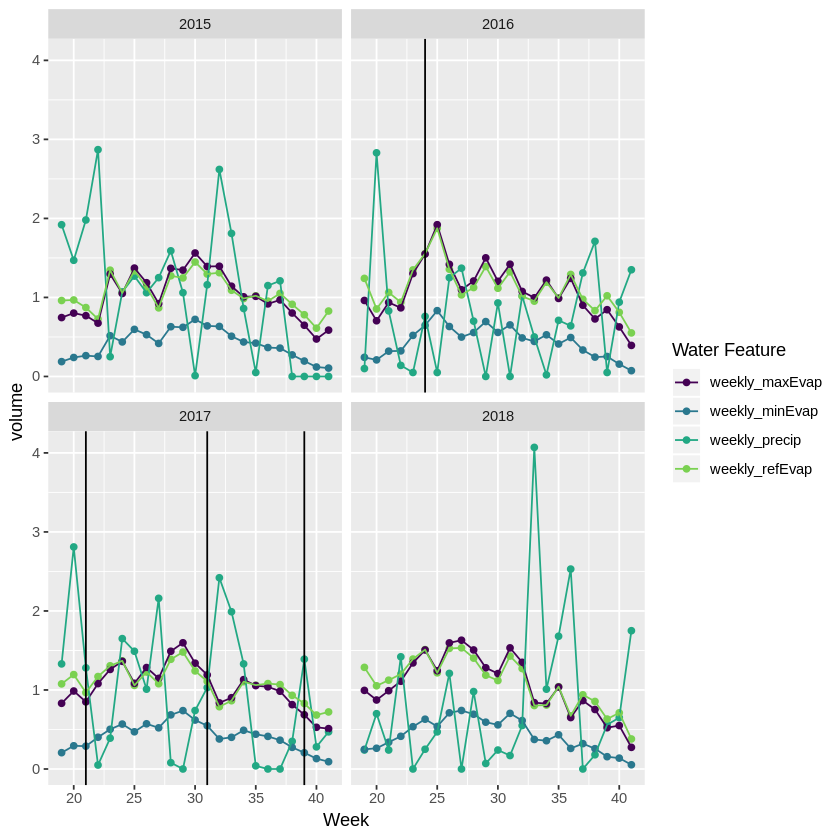

In [273]:
vline.year <- c(2016, 2017, 2017, 2017)
vline.date <- c(24, 21, 31, 39)
vline <- data.frame('Year'=vline.year, "tmp_date"=vline.date)
vline

to_plot <- to_plot[to_plot$Week >= 19 & to_plot$Week <= 41,]

p <- ggplot(to_plot, aes(x=Week, y=volume, color=GL)) + 
     geom_point() + 
     geom_line() + 
     #geom_area(aes(fill=Year), position='identity', alpha=0.3) + 
     scale_color_manual(name="Water Feature", values=c_pal[c(1,3,4,5)]) + #, labels=c('Max. Proj.', 'Min. Proj.', 'Precip.')) + 
     #scale_x_date(labels = date_format("%b")) + 
     facet_wrap('Year') + 
     geom_vline(data=vline, aes(xintercept=tmp_date))
p

In [ ]:
vline.year <- c(2016, 2017, 2017, 2017)
vline.date <- c(24, 21, 31, 39)
vline <- data.frame('Year'=vline.year, "tmp_date"=vline.date)
vline

to_plot <- to_plot[to_plot$Week >= 19 & to_plot$Week <= 41,]

p <- ggplot(to_plot, aes(x=Week, y=volume, color=GL)) + 
     geom_point() + 
     geom_line() + 
     #geom_area(aes(fill=Year), position='identity', alpha=0.3) + 
     scale_color_manual(name="Water Feature", values=c_pal[c(1,3,4,5)]) + #, labels=c('Max. Proj.', 'Min. Proj.', 'Precip.')) + 
     #scale_x_date(labels = date_format("%b")) + 
     facet_wrap('Year') + 
     geom_vline(data=vline, aes(xintercept=tmp_date))
p

In [324]:
getMode <- function(v) {
   uniqv <- unique(v)
   return(uniqv[which.max(tabulate(match(v, uniqv)))])
}

summarise_evap <- function(df) {
    to_plot <- df %>% group_by(Group) %>% 
               summarise(weekly_precip=sum(Precip), weekly_refEvap=sum(evap), 
               weekly_maxEvap=sum(maxEvap), weekly_minEvap=sum(minEvap), Year=getMode(Year))
    return(to_plot)
}

Something something it doesn't look like it takes very long to recover from drought stress. [This paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5432590/) shows that even after 40 days of continued stress, all vines are mostly recovered in a few days as measured by stomatal condunctance ($g_s$). 

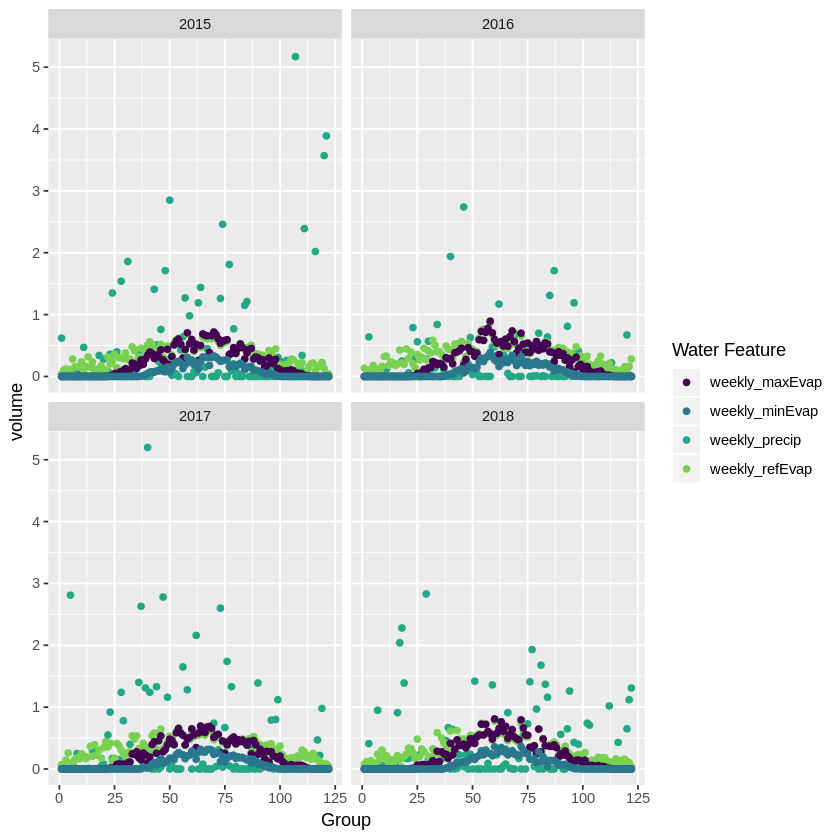

In [348]:
weather_tmp <- weather %>% select(Month:rad)
weather_tmp$date <- paste(weather_tmp$Year, weather_tmp$Month, weather_tmp$Day, sep='-')
weather_tmp$date <- as.Date(weather_tmp$date)
weather_tmp$Year <- as.factor(weather_tmp$Year)
weather_tmp <- weather_tmp[weather_tmp$Year != 2014,] %>% select(Year, Precip, date, evap)
weather_tmp$tmp_date <- as.Date(paste(rep("1904", length(weather_tmp$date)), 
                                           month(weather_tmp$date), day(weather_tmp$date), sep='-'))

to_plot <- weather_tmp %>% dplyr::select(Year, Precip, evap)

for (year in c('2015', '2016', '2017', '2018')){
    if (year == '2016'){
        end_idx <- 366
    } else {
        end_idx <- 365
    }
    temp_df <- to_plot[to_plot$Year == as.integer(year),]
    temp_df$evap_min <- temp_df$evap * ks_gather[ks_gather$paradigm == 'max0.5',]$Ks[1:end_idx]
    colnames(temp_df) <- c('Year', 'Precip', 'evap', 'minEvap')
    temp_df$evap_max <- temp_df$evap * ks_gather[ks_gather$paradigm == 'max1.08',]$Ks[1:end_idx]
    colnames(temp_df) <- c('Year', 'Precip', 'evap', 'minEvap', 'maxEvap')
    if (as.integer(year) == 2015){
        temp_df$Group <- rep(1:122, each=3)[1:365]
        temp_df <- summarise_evap(temp_df)
        evap_projections <- temp_df
    } else if(as.integer(year) == 2016) {
        temp_df$Group <- rep(1:122, each=3)
        temp_df <- summarise_evap(temp_df)
        evap_projections <- rbind(evap_projections, temp_df)
    } else {
        temp_df$Group <- rep(1:122, each=3)[1:365]
        temp_df <- summarise_evap(temp_df)
        evap_projections <- rbind(evap_projections, temp_df)
    }
}

# to_plot <- evap_projections %>% group_by(Group) %>% 
#                            summarise(weekly_precip=sum(Precip), weekly_refEvap=sum(evap), 
#                                      weekly_maxEvap=sum(maxEvap), weekly_minEvap=sum(minEvap))


to_plot <- evap_projections %>% gather(key='GL', value='volume', -Year, -Group)

p <- ggplot(to_plot, aes(x=Group, y=volume, color=GL)) + 
     geom_point() + 
     #geom_area(aes(fill=Year), position='identity', alpha=0.3) + 
     scale_color_manual(name="Water Feature", values=c_pal[c(1,3,4,5)]) + #, labels=c('Max. Proj.', 'Min. Proj.', 'Precip.')) + 
     #scale_x_date(labels = date_format("%b")) + 
     facet_wrap('Year')
p

In [349]:
as.numeric(as.Date("2017-05-01") - as.Date("2017-01-01"))/3
as.numeric(as.Date("2017-10-25") - as.Date("2017-01-01"))/3


as.numeric(as.Date("2016-06-14") - as.Date("2016-01-01"))/3
as.numeric(as.Date("2017-05-22") - as.Date("2017-01-01"))/3
as.numeric(as.Date("2017-07-30") - as.Date("2017-01-01"))/3
as.numeric(as.Date("2017-09-25") - as.Date("2017-01-01"))/3

[1] 40

[1] 99

[1] 55

[1] 47

[1] 70

[1] 89

Year,tmp_date
<dbl>,<dbl>
2016,55
2017,47
2017,70
2017,89


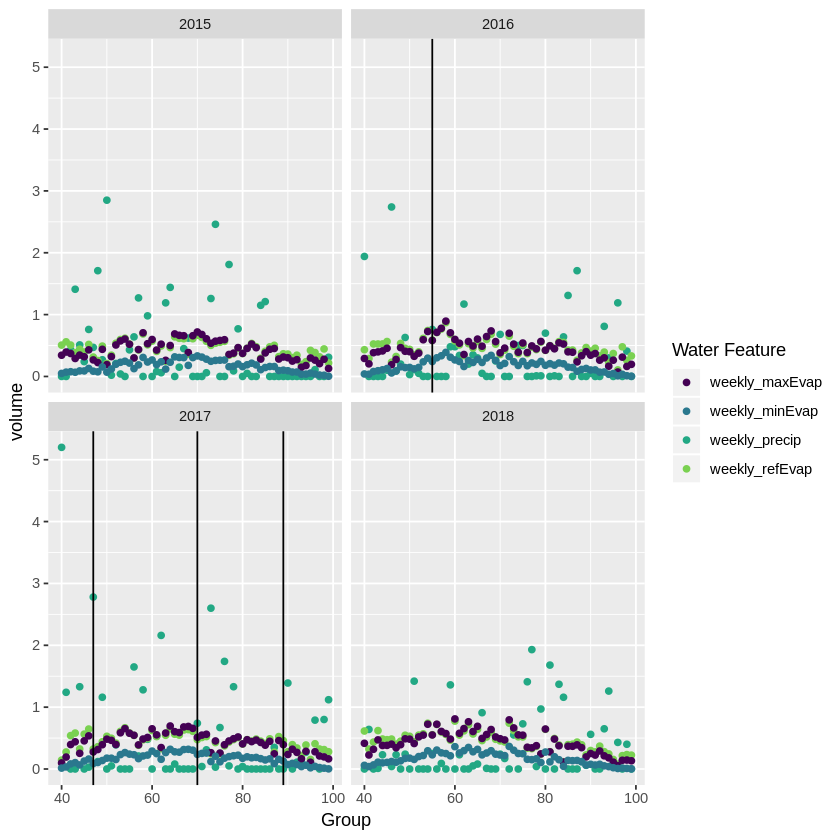

In [350]:
vline.year <- c(2016, 2017, 2017, 2017)
vline.date <- c(55, 47, 70, 89)
vline <- data.frame('Year'=vline.year, "tmp_date"=vline.date)
vline

to_plot <- to_plot[to_plot$Group >=40 & to_plot$Group <= 99,]

p <- ggplot(to_plot, aes(x=Group, y=volume, color=GL)) + 
     geom_point() + 
     #geom_line() + 
     scale_color_manual(name="Water Feature", values=c_pal[c(1,3,4,5)]) + #, labels=c('Max. Proj.', 'Min. Proj.', 'Precip.')) + 
     facet_wrap('Year') + 
     geom_vline(data=vline, aes(xintercept=tmp_date))
p

[1] 120

[1] 297

[1] 165

[1] 141

[1] 210

[1] 267

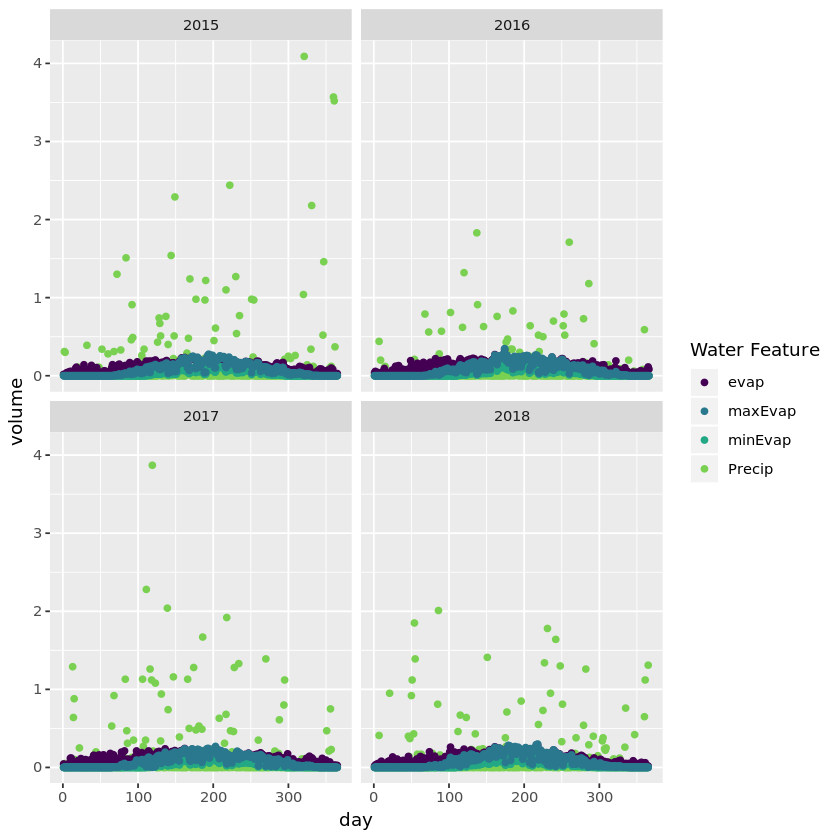

In [35]:
weather_tmp <- weather %>% select(Month:rad)
weather_tmp$date <- paste(weather_tmp$Year, weather_tmp$Month, weather_tmp$Day, sep='-')
weather_tmp$date <- as.Date(weather_tmp$date)
weather_tmp$Year <- as.factor(weather_tmp$Year)
weather_tmp <- weather_tmp[weather_tmp$Year != 2014,] %>% select(Year, Precip, date, evap)
weather_tmp$tmp_date <- as.Date(paste(rep("1904", length(weather_tmp$date)), 
                                           month(weather_tmp$date), day(weather_tmp$date), sep='-'))

to_plot <- weather_tmp %>% dplyr::select(Year, Precip, evap)

for (year in c('2015', '2016', '2017', '2018')){
    if (year == '2016'){
        end_idx <- 366
    } else {
        end_idx <- 365
    }
    temp_df <- to_plot[to_plot$Year == as.integer(year),]
    temp_df$evap_min <- temp_df$evap * ks_gather[ks_gather$paradigm == 'max0.5',]$Ks[1:end_idx]
    colnames(temp_df) <- c('Year', 'Precip', 'evap', 'minEvap')
    temp_df$evap_max <- temp_df$evap * ks_gather[ks_gather$paradigm == 'max1.08',]$Ks[1:end_idx]
    colnames(temp_df) <- c('Year', 'Precip', 'evap', 'minEvap', 'maxEvap')
    if (as.integer(year) == 2015){
        temp_df$day <- 1:365
        evap_projections <- temp_df
    } else if(as.integer(year) == 2016) {
        temp_df$day <- 1:366
        evap_projections <- rbind(evap_projections, temp_df)
    } else {
        temp_df$day <- 1:365
        evap_projections <- rbind(evap_projections, temp_df)
    }
}

to_plot <- evap_projections %>% gather(key='GL', value='volume', -Year, -day)

p <- ggplot(to_plot, aes(x=day, y=volume, color=GL)) + 
     geom_point() + 
     #geom_line() + 
     scale_color_manual(name="Water Feature", values=c_pal[c(1,3,4,5)]) + #, labels=c('Max. Proj.', 'Min. Proj.', 'Precip.')) + 
     facet_wrap('Year') #+ 
     #geom_vline(data=vline, aes(xintercept=tmp_date))
p

In [33]:
as.numeric(as.Date("2017-05-01") - as.Date("2017-01-01"))
as.numeric(as.Date("2017-10-25") - as.Date("2017-01-01"))


as.numeric(as.Date("2016-06-14") - as.Date("2016-01-01"))
as.numeric(as.Date("2017-05-22") - as.Date("2017-01-01"))
as.numeric(as.Date("2017-07-30") - as.Date("2017-01-01"))
as.numeric(as.Date("2017-09-25") - as.Date("2017-01-01"))

as.numeric(as.Date("2018-05-30") - as.Date("2018-01-01"))
as.numeric(as.Date("2018-08-01") - as.Date("2018-01-01"))
as.numeric(as.Date("2018-09-17") - as.Date("2018-01-01"))

[1] 120

[1] 297

[1] 165

[1] 141

[1] 210

[1] 267

[1] 149

[1] 212

[1] 259

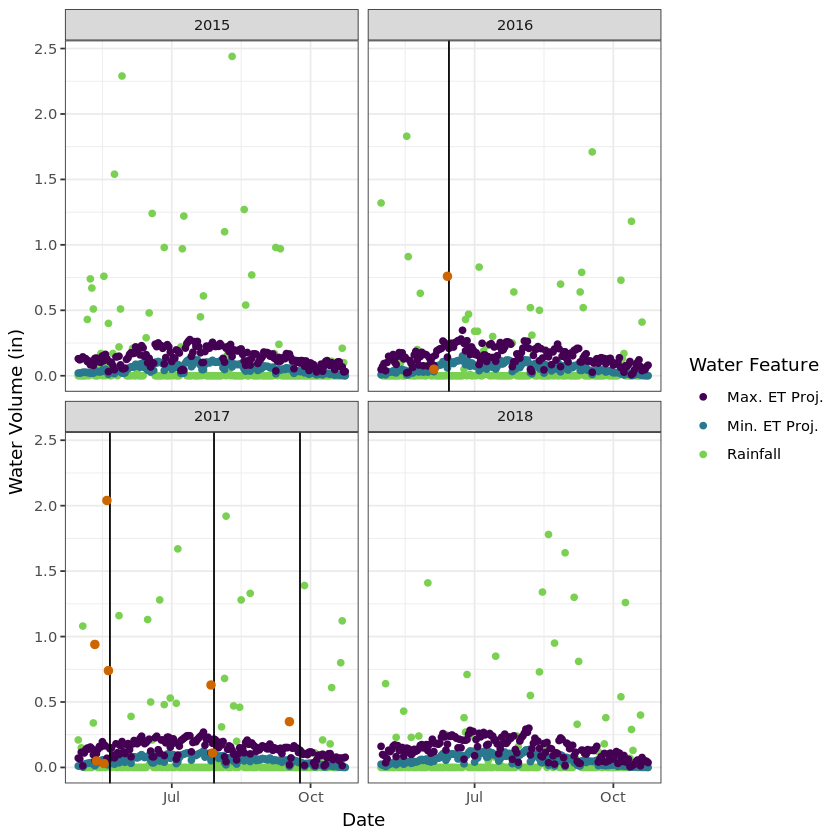

In [36]:
to_plot <- to_plot[to_plot$day >= 120 & to_plot$day <= 297,]

isCloseSampling <- function(dfrow){
    year <- dfrow[1]
    day <- dfrow[2]
    if (year == 2015 | year == 2018){
        return(0)
    } else if (year == 2016){
        if (day >= 155 & day <= 165){
            return(1)
        } else {
            return (0)
        }
    } else if (year == 2017){
        if ((day >= 131 & day <= 141) | (day >= 200 & day <= 210) | (day >= 257 & day <= 267)){
            return(1)
        } else {
            return(0)
        }
    }
}

to_plot$isCloseSampling <- unlist(apply(to_plot, 1, FUN=isCloseSampling), use.names=FALSE)
tmp_plot <- to_plot[to_plot$GL == 'Precip' | to_plot$GL == 'maxEvap' | to_plot$GL == 'minEvap',]
red_points <- to_plot[to_plot$GL == 'Precip' & to_plot$isCloseSampling == 1 & to_plot$volume > 0.00,]

vline.year <- c(2016, 2017, 2017, 2017)
vline.date <- c(165, 141, 210, 267)
vline <- data.frame('Year'=vline.year, "tmp_date"=vline.date)


snFig2b <- ggplot(tmp_plot, aes(x=as.Date(day, origin="2016-01-01"), y=volume, color=GL)) + 
     geom_point() + 
     scale_color_manual(name="Water Feature", values=c_pal[c(1,3,5)], labels=c('Max. ET Proj.', 'Min. ET Proj.', 'Rainfall')) + 
     facet_wrap('Year') + xlab('Date') + ylab('Water Volume (in)') + 
     geom_vline(data=vline, aes(xintercept=as.Date(tmp_date, origin="2016-01-01"))) + 
     geom_point(data=red_points, size=2,aes(color=isCloseSampling), color='darkorange3') + 
     theme_bw()
snFig2b

In [507]:
library('ggpubr')

Loading required package: magrittr

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract



In [535]:
pdf('2017_Irrigation_snFigures.pdf', width=8, height=4)
  ggarrange(snFig2a, snFig2b, ncol=2, common.legend=2, legend='right', labels=c('A', 'B'))
dev.off()

png 
  2

## For Joel - 2018 only

#### All Sampling Dates Shown

Year,tmp_date
<dbl>,<date>
2018,1904-05-30
2018,1904-08-01
2018,1904-09-17


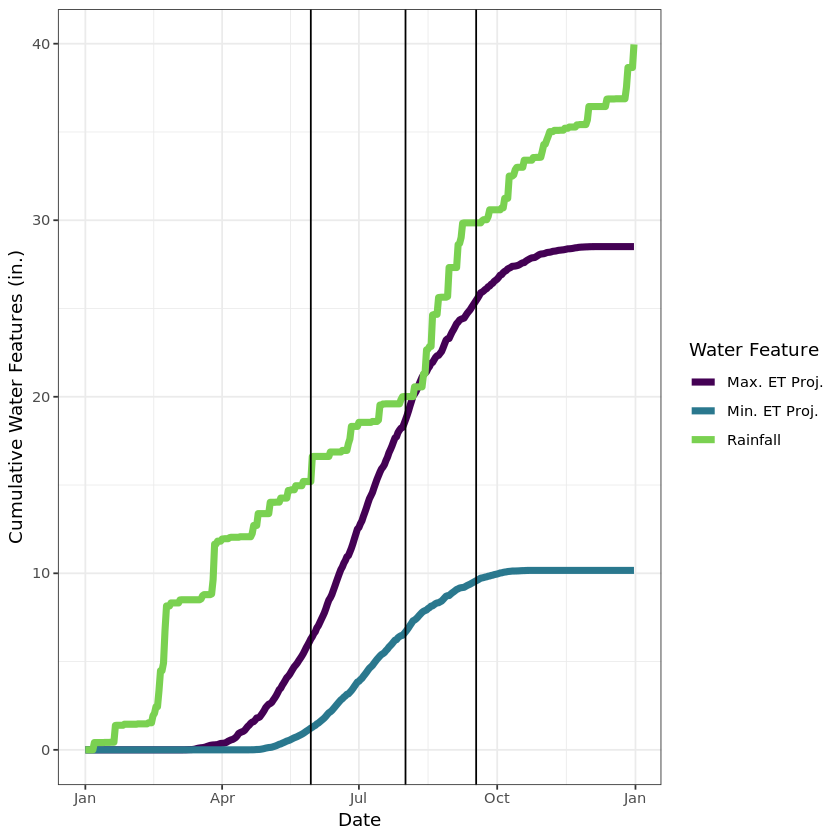

In [31]:
jdf <- df[df$Year==2018,]

vline.year <- c(2018, 2018, 2018)
vline.date <- c(as.Date('1904-05-30'), as.Date('1904-08-01'), as.Date('1904-09-17'))
vline <- data.frame('Year'=vline.year, "tmp_date"=vline.date)
vline


jFig1a <- ggplot(jdf, aes(x=tmp_date, y=cummulative.water, color=feature)) + 
     geom_line(lwd=2) + 
     #geom_area(aes(fill=Year), position='identity', alpha=0.3) + 
     scale_color_manual(name="Water Feature", values=c_pal[c(1,3,5)], labels=c('Max. ET Proj.', 'Min. ET Proj.', 'Rainfall')) + 
     scale_x_date(labels = date_format("%b")) +
     #facet_wrap('Year') + 
     geom_vline(data=vline, aes(xintercept=tmp_date)) + 
     xlab('Date') + ylab('Cumulative Water Features (in.)') + theme_bw()

jFig1a


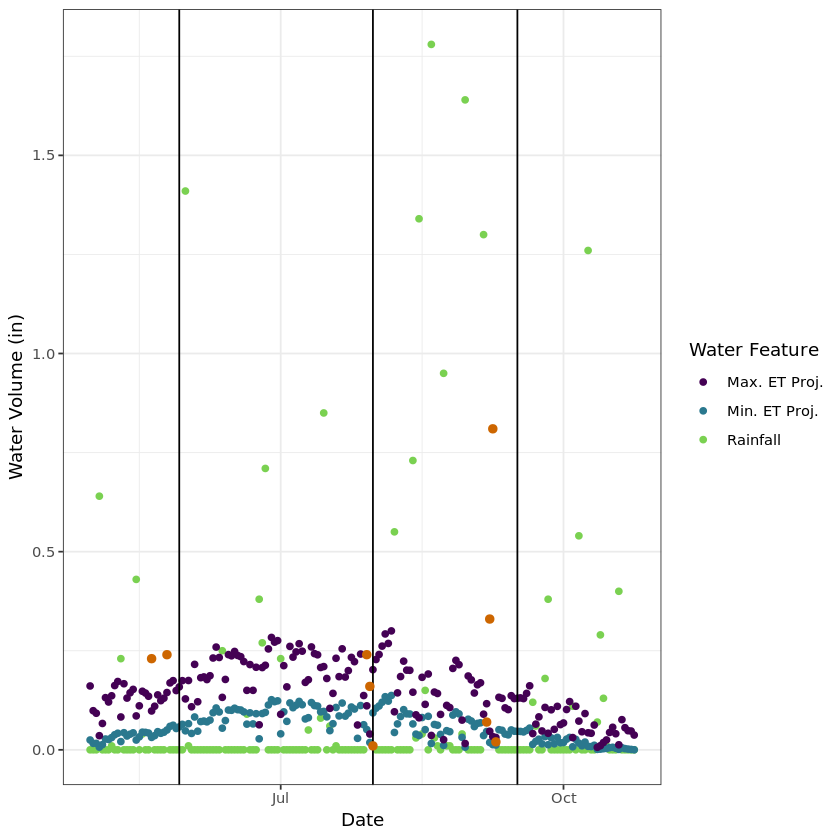

In [38]:
to_plot <- to_plot[to_plot$day >= 120 & to_plot$day <= 297,]

isCloseSampling <- function(dfrow){
    year <- dfrow[1]
    day <- dfrow[2]
    if (year == 2015){
        return(0)
    } else if (year == 2016){
        if (day >= 155 & day <= 165){
            return(1)
        } else {
            return (0)
        }
    } else if (year == 2017){
        if ((day >= 131 & day <= 141) | (day >= 200 & day <= 210) | (day >= 257 & day <= 267)){
            return(1)
        } else {
            return(0)
        }
    } else if (year == 2018){
        if ((day >= 139 & day <= 149) | (day >= 202 & day <= 212) | (day >= 249 & day <= 259)){
            return(1)
        } else {
            return(0) 
        }
    }
}

to_plot <- to_plot[to_plot$Year == 2018,]

to_plot$isCloseSampling <- unlist(apply(to_plot, 1, FUN=isCloseSampling), use.names=FALSE)
tmp_plot <- to_plot[to_plot$GL == 'Precip' | to_plot$GL == 'maxEvap' | to_plot$GL == 'minEvap',]
red_points <- to_plot[to_plot$GL == 'Precip' & to_plot$isCloseSampling == 1 & to_plot$volume > 0.00,]

vline.year <- c(2018, 2018, 2018)
vline.date <- c(149, 212, 259)
vline <- data.frame('Year'=vline.year, "tmp_date"=vline.date)


jFig1b <- ggplot(tmp_plot, aes(x=as.Date(day, origin="2016-01-01"), y=volume, color=GL)) + 
     geom_point() + 
     scale_color_manual(name="Water Feature", values=c_pal[c(1,3,5)], labels=c('Max. ET Proj.', 'Min. ET Proj.', 'Rainfall')) + 
     xlab('Date') + ylab('Water Volume (in)') + 
     geom_vline(data=vline, aes(xintercept=as.Date(tmp_date, origin="2016-01-01"))) + 
     geom_point(data=red_points, size=2,aes(color=isCloseSampling), color='darkorange3') + 
     theme_bw()
jFig1b

In [41]:
pdf('2018_weather_Joel_allSampling.pdf', height=4, width=10)
  ggpubr::ggarrange(jFig1a, jFig1b, ncol=2, common.legend=T, legend='right')
dev.off()

png 
  2

#### Only Harvest Highlighted

Year,tmp_date
<dbl>,<date>
2018,1904-09-17


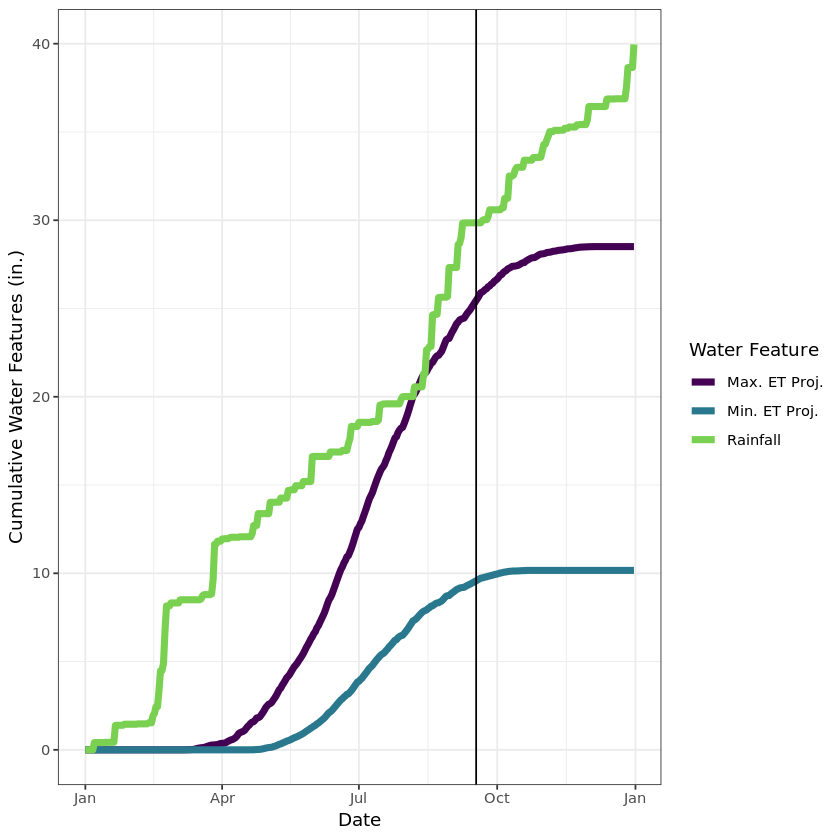

In [42]:
jdf <- df[df$Year==2018,]

vline.year <- c(2018)
vline.date <- c(as.Date('1904-09-17'))
vline <- data.frame('Year'=vline.year, "tmp_date"=vline.date)
vline


jhFig1a <- ggplot(jdf, aes(x=tmp_date, y=cummulative.water, color=feature)) + 
     geom_line(lwd=2) + 
     #geom_area(aes(fill=Year), position='identity', alpha=0.3) + 
     scale_color_manual(name="Water Feature", values=c_pal[c(1,3,5)], labels=c('Max. ET Proj.', 'Min. ET Proj.', 'Rainfall')) + 
     scale_x_date(labels = date_format("%b")) +
     #facet_wrap('Year') + 
     geom_vline(data=vline, aes(xintercept=tmp_date)) + 
     xlab('Date') + ylab('Cumulative Water Features (in.)') + theme_bw()

jhFig1a

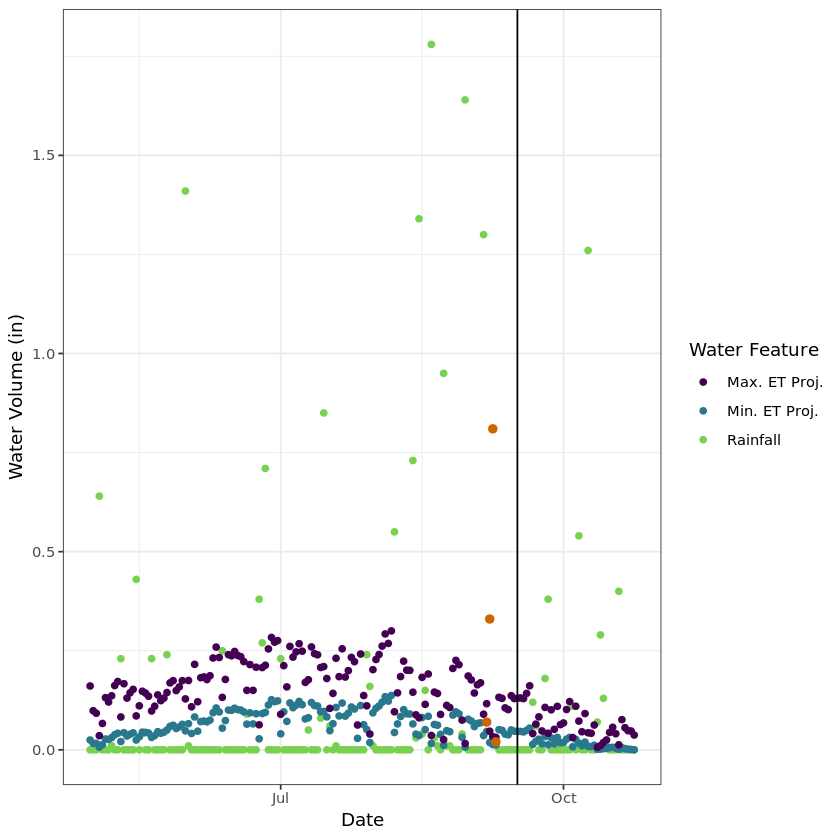

In [44]:
to_plot <- to_plot[to_plot$day >= 120 & to_plot$day <= 297,]

isCloseSampling <- function(dfrow){
    year <- dfrow[1]
    day <- dfrow[2]
    if (year == 2015){
        return(0)
    } else if (year == 2016){
        if (day >= 155 & day <= 165){
            return(1)
        } else {
            return (0)
        }
    } else if (year == 2017){
        if ((day >= 131 & day <= 141) | (day >= 200 & day <= 210) | (day >= 257 & day <= 267)){
            return(1)
        } else {
            return(0)
        }
    } else if (year == 2018){
        if (day >= 249 & day <= 259){
            return(1)
        } else {
            return(0) 
        }
    }
}

to_plot <- to_plot[to_plot$Year == 2018,]

to_plot$isCloseSampling <- unlist(apply(to_plot, 1, FUN=isCloseSampling), use.names=FALSE)
tmp_plot <- to_plot[to_plot$GL == 'Precip' | to_plot$GL == 'maxEvap' | to_plot$GL == 'minEvap',]
red_points <- to_plot[to_plot$GL == 'Precip' & to_plot$isCloseSampling == 1 & to_plot$volume > 0.00,]

vline.year <- c(2018)
vline.date <- c(259)
vline <- data.frame('Year'=vline.year, "tmp_date"=vline.date)


jhFig1b <- ggplot(tmp_plot, aes(x=as.Date(day, origin="2016-01-01"), y=volume, color=GL)) + 
     geom_point() + 
     scale_color_manual(name="Water Feature", values=c_pal[c(1,3,5)], labels=c('Max. ET Proj.', 'Min. ET Proj.', 'Rainfall')) + 
     xlab('Date') + ylab('Water Volume (in)') + 
     geom_vline(data=vline, aes(xintercept=as.Date(tmp_date, origin="2016-01-01"))) + 
     geom_point(data=red_points, size=2,aes(color=isCloseSampling), color='darkorange3') + 
     theme_bw()
jhFig1b

In [45]:
pdf('2018_weather_Joel_harvest.pdf', height=4, width=10)
  ggpubr::ggarrange(jhFig1a, jhFig1b, ncol=2, common.legend=T, legend='right')
dev.off()

png 
  2

In [463]:
as.Date(200, origin="2016-01-01")

[1] "2016-07-19"

In [357]:
rainfall_2015 <- to_plot$volume[to_plot$Year == 2015]

In [370]:
compute_pr <- function(data, k){
    m <- mean(data)
    v <- var(data)
    l <-((v + m^2)/ m) - 1
    p <- (v - m) / (v + m^2 - m)
    #return(1 - p) * (l^k * exp(-l)) / factorial(k)
    return(c(m, v, l, p))
}

In [371]:
compute_pr(rainfall_2015, k=0)

[1]  0.12180188  0.03755955 -0.56983216  1.21375046

In [199]:
weather_tmp_2015 <- weather_tmp[weather_tmp$Year == 2015,]
weather_tmp_2016 <- weather_tmp[weather_tmp$Year == 2016,]
weather_tmp_2017 <- weather_tmp[weather_tmp$Year == 2017,]
weather_tmp_2018 <- weather_tmp[weather_tmp$Year == 2018,]

weather_tmp_2015 <- get_accumulatedEvap(weather_tmp_2015)
weather_tmp_2016 <- get_accumulatedEvap(weather_tmp_2016)
weather_tmp_2017 <- get_accumulatedEvap(weather_tmp_2017)
weather_tmp_2018 <- get_accumulatedEvap(weather_tmp_2018)

weather_tmp <- rbind(weather_tmp_2015, weather_tmp_2016, weather_tmp_2017, weather_tmp_2018)


head(weather_tmp)

,Year,evap,date,tmp_date,ndays
,<fct>,<dbl>,<date>,<date>,<int>
239,2015,0.018,2015-01-01,1904-01-01,0
240,2015,0.026,2015-01-02,1904-01-02,1
241,2015,0.041,2015-01-03,1904-01-03,2
242,2015,0.063,2015-01-04,1904-01-04,3
243,2015,0.101,2015-01-05,1904-01-05,4
244,2015,0.143,2015-01-06,1904-01-06,5


In [200]:
weather_tmp$tmp_date <- as.Date(paste(rep("1904", length(weather_tmp$date)), month(weather_tmp$date), day(weather_tmp$date), sep='-'))

weather_tmp$ndays <- as.integer(as.Date('2015-01-01') - weather_tmp$tmp_date)
weather_tmp$ndays <- abs(weather_tmp$ndays - max(weather_tmp$ndays))
head(weather_tmp)

,Year,evap,date,tmp_date,ndays
,<fct>,<dbl>,<date>,<date>,<int>
239,2015,0.018,2015-01-01,1904-01-01,0
240,2015,0.026,2015-01-02,1904-01-02,1
241,2015,0.041,2015-01-03,1904-01-03,2
242,2015,0.063,2015-01-04,1904-01-04,3
243,2015,0.101,2015-01-05,1904-01-05,4
244,2015,0.143,2015-01-06,1904-01-06,5


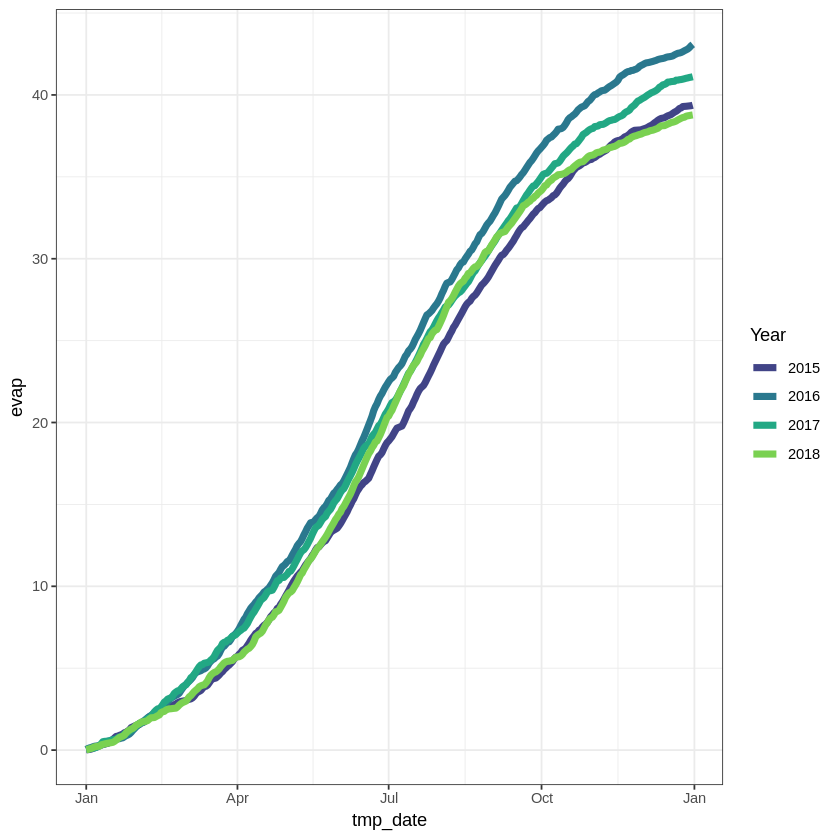

In [201]:
p <- ggplot(weather_tmp, aes(x=tmp_date, y=evap, color=Year)) + 
     geom_line(lwd=2) + 
     scale_color_manual(name="Year", values=c_pal[2:5]) + 
     scale_x_date(labels = date_format("%b")) + 
     #geom_smooth(method='lm', lty=1) + 
     theme_bw()
p

In [202]:
evaplm <- lm(evap ~ Year + ndays + I(ndays^2) + I(ndays^3) + ndays*Year + I(ndays^2)*Year + I(ndays^3)*Year, data=weather_tmp)

#change options for the lms
oldc <- getOption("contrasts")
options(contrasts=c('contr.sum','contr.poly'))

evapAnova <- car::Anova(evaplm, type=3)

# reset base contrasts so nothing is too broken
options(contrasts = oldc)

In [204]:
evap.emt <- emtrends(evaplm, 'Year', var='ndays', max.degree=3)
as.data.frame(evap.emt)
res <- pairs(evap.emt)
res <- as.data.frame(res)
res[res$p.value < 0.05,]

Year,degree,ndays.trend,SE,df,lower.CL,upper.CL
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2015,linear,1.637762e-01,4.751745e-04,1445,1.628441e-01,1.647083e-01
2016,linear,1.756464e-01,4.744444e-04,1445,1.747157e-01,1.765771e-01
2017,linear,1.645162e-01,4.751745e-04,1445,1.635841e-01,1.654483e-01
2018,linear,1.735733e-01,4.751745e-04,1445,1.726412e-01,1.745054e-01
2015,quadratic,2.074099e-05,2.008771e-06,1445,1.680057e-05,2.468141e-05
2016,quadratic,-2.339902e-05,2.008295e-06,1445,-2.733851e-05,-1.945954e-05
2017,quadratic,-1.379388e-05,2.008771e-06,1445,-1.773430e-05,-9.853465e-06
2018,quadratic,-3.672962e-05,2.008771e-06,1445,-4.067004e-05,-3.278920e-05
2015,cubic,-1.798589e-06,2.165400e-08,1445,-1.841065e-06,-1.756112e-06


,contrast,degree,estimate,SE,df,t.ratio,p.value
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2015 - 2016,linear,-1.187019e-02,6.714821e-04,1445,-17.677603,0.000000e+00
3,2015 - 2018,linear,-9.797109e-03,6.719982e-04,1445,-14.579071,0.000000e+00
4,2016 - 2017,linear,1.113021e-02,6.714821e-04,1445,16.575584,0.000000e+00
5,2016 - 2018,linear,2.073085e-03,6.714821e-04,1445,3.087328,1.106336e-02
6,2017 - 2018,linear,-9.057123e-03,6.719982e-04,1445,-13.477898,0.000000e+00
7,2015 - 2016,quadratic,4.414001e-05,2.840495e-06,1445,15.539547,0.000000e+00
8,2015 - 2017,quadratic,3.453487e-05,2.840832e-06,1445,12.156605,0.000000e+00
9,2015 - 2018,quadratic,5.747060e-05,2.840832e-06,1445,20.230204,0.000000e+00
10,2016 - 2017,quadratic,-9.605138e-06,2.840495e-06,1445,-3.381501,4.119031e-03


In [85]:
evapAnova

,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),22.636940,1,153.84203,1.209278e-33
Year,6.853357,3,15.52528,6.083438e-10
ndays,23.865070,1,162.18848,2.745170e-35
I(ndays^2),1031.878836,1,7012.71193,0.000000e+00
I(ndays^3),1015.149776,1,6899.02021,0.000000e+00
Year:ndays,51.277525,3,116.16174,2.164915e-67
Year:I(ndays^2),49.542673,3,112.23168,2.506056e-65
Year:I(ndays^3),60.681025,3,137.46399,2.388059e-78
Residuals,212.623152,1445,NA,NA


A similar method by which to address this question is a cointegration test which examines two time series and asks whether those time series are cointegrated. Specifically, it asks whether two $I(1)$ functions are responding to the same trend (either measured or stochastic). If they are, then there should be some value $\theta$ such that $f_1 (x) - \theta f_2(x)$ is $I(0)$. 

Response: weather_tmp$Precip 
Input: weather_tmp$ndays 
Number of inputs: 1 
Model: y ~ X + 1 
------------------------------- 
Engle-Granger Cointegration Test 
alternative: cointegrated 

Type 1: no trend 
    lag      EG p.value 
   7.00   -1.96    0.10 
----- 
 Type 2: linear trend 
    lag      EG p.value 
 7.0000 -0.0176  0.1000 
----- 
 Type 3: quadratic trend 
    lag      EG p.value 
  7.000   0.207   0.100 
----------- 
Note: p.value = 0.01 means p.value <= 0.01 
    : p.value = 0.10 means p.value >= 0.10 
